In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid

from cuml.ensemble import RandomForestClassifier

sns.set(style="whitegrid", context="notebook")


##### NOTE: THE NOTEBOOK WILL ONLY RUN ON MACHINE THAT SUPPORTS CUML

In [2]:
df = pd.read_csv(
    "amazon_dataset.csv",
    dtype={"order_id": str},
    low_memory=False,
)

columns_to_remove = [
    "bi_st",
    "cust_id",
    "ref_num",
    "First Name",
    "Middle Initial",
    "Last Name",
    "full_name",
    "E Mail",
    "Phone No. ",
    "User Name",
]

df = df.drop(columns=columns_to_remove, errors="ignore")

df.head()

,order_id,order_date,status,item_id,sku,qty_ordered,price,value,discount_amount,total,...,Gender,age,Sign in date,Place Name,County,City,State,Zip,Region,Discount_Percent
0,100354678,01/10/2020,received,574772,oasis_Oasis-064-36,21,89.9,1798.0,0.0,1798.0,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
1,100354678,01/10/2020,received,574774,Fantastic_FT-48,11,19.0,190.0,0.0,190.0,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
2,100354680,01/10/2020,complete,574777,mdeal_DMC-610-8,9,149.9,1199.2,0.0,1199.2,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
3,100354680,01/10/2020,complete,574779,oasis_Oasis-061-36,9,79.9,639.2,0.0,639.2,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
4,100367357,13/11/2020,received,595185,MEFNAR59C38B6CA08CD,2,99.9,99.9,0.0,99.9,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0


In [3]:
status_complete = {"complete", "received"}
status_incomplete = {"canceled", "order_refunded", "refund"}
eligible_statuses = status_complete | status_incomplete

filtered = df[df["status"].isin(eligible_statuses)].copy()
filtered["order_complete"] = filtered["status"].isin(status_complete).astype(int)

status_summary = filtered["status"].value_counts().rename_axis("status").reset_index(name="count")
status_summary


,status,count
0,canceled,112166
1,complete,88968
2,received,51775
3,order_refunded,25713
4,refund,3820


In [4]:
model_df = filtered.copy()

model_df["order_date"] = pd.to_datetime(model_df["order_date"], dayfirst=True, errors="coerce")
model_df["signin_date"] = pd.to_datetime(model_df["Sign in date"], errors="coerce")
model_df["order_month"] = model_df["order_date"].dt.month
model_df["order_day"] = model_df["order_date"].dt.day
model_df["order_dayofweek"] = model_df["order_date"].dt.dayofweek
model_df["order_quarter"] = model_df["order_date"].dt.quarter
model_df["signup_years_active"] = (
    (model_df["order_date"] - model_df["signin_date"]).dt.days / 365.25
)

for col in ["qty_ordered", "price", "value", "discount_amount", "total", "age", "year", "Discount_Percent"]:
    model_df[col] = pd.to_numeric(model_df[col], errors="coerce")

model_df["price_per_item"] = model_df["value"] / (model_df["qty_ordered"] + 1e-6)
model_df["discount_ratio"] = model_df["discount_amount"] / (model_df["value"] + 1e-6)
model_df["has_discount"] = (model_df["discount_amount"] > 0).astype(int)
model_df["total_per_item"] = model_df["total"] / (model_df["qty_ordered"] + 1e-6)
model_df["value_to_total_ratio"] = model_df["value"] / (model_df["total"] + 1e-6)

numeric_features = [
    "qty_ordered",
    "price",
    "value",
    "discount_amount",
    "total",
    "age",
    "year",
    "Discount_Percent",
    "order_month",
    "order_day",
    "order_dayofweek",
    "order_quarter",
    "signup_years_active",
    "price_per_item",
    "discount_ratio",
    "has_discount",
    "total_per_item",
    "value_to_total_ratio",
]

categorical_features = [
    "category",
    "payment_method",
    "Gender",
    "Region",
    "State",
]

feature_cols = numeric_features + categorical_features

data = model_df[feature_cols + ["order_complete"]].dropna(subset=["order_complete"])
data.head()


,qty_ordered,price,value,discount_amount,total,age,year,Discount_Percent,order_month,order_day,...,discount_ratio,has_discount,total_per_item,value_to_total_ratio,category,payment_method,Gender,Region,State,order_complete
0,21,89.9,1798.0,0.0,1798.0,43,2020,0.0,10,1,...,0.0,0,85.619044,1.0,Men's Fashion,cod,F,South,OK,1
1,11,19.0,190.0,0.0,190.0,43,2020,0.0,10,1,...,0.0,0,17.272726,1.0,Men's Fashion,cod,F,South,OK,1
2,9,149.9,1199.2,0.0,1199.2,43,2020,0.0,10,1,...,0.0,0,133.244430,1.0,Men's Fashion,cod,F,South,OK,1
3,9,79.9,639.2,0.0,639.2,43,2020,0.0,10,1,...,0.0,0,71.022214,1.0,Men's Fashion,cod,F,South,OK,1
4,2,99.9,99.9,0.0,99.9,43,2020,0.0,11,13,...,0.0,0,49.949975,1.0,Men's Fashion,cod,F,South,OK,1


In [5]:
X = data[feature_cols]
y = data["order_complete"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01),
        ),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

num_feature_names = numeric_features
cat_encoder = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])


# cuML RandomForest
param_grid = {
    # "n_estimators": [200, 300, 400],
    # "max_depth": [15, 20, 25],
    # "min_samples_split": [5, 10],
    # "min_samples_leaf": [2, 5],
    # "max_features": ["sqrt", 0.5],
    "n_estimators": [300],
    "max_depth": [25],
    "min_samples_split": [5],
    "min_samples_leaf": [2],
    "max_features": [0.5],
}

total_combos = len(list(ParameterGrid(param_grid)))

best_score = 0
best_params = None
best_model = None

param_list = list(ParameterGrid(param_grid))
start_time = time.time()

for i, params in enumerate(param_list):
    rf = RandomForestClassifier(random_state=42, **params)
    scores = cross_val_score(rf, X_train_processed, y_train, cv=3, scoring="accuracy", n_jobs=1)
    mean_score = scores.mean()
    
    elapsed = time.time() - start_time
    avg_time = elapsed / (i + 1)
    remaining = avg_time * (total_combos - i - 1)
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = rf

best_model.fit(X_train_processed, y_train)
# Create a mock grid_search object for compatibility
class MockGridSearch:
    def __init__(self, estimator, params, score):
        self.best_estimator_ = estimator
        self.best_params_ = params
        self.best_score_ = score

grid_search = MockGridSearch(best_model, best_params, best_score)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")


Best parameters: {'max_depth': 25, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV accuracy: 0.7592


Best CV accuracy: 0.7592
Train accuracy: 0.8968
Test accuracy: 0.7699
Overfitting gap: 0.1270
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     28340
           1       0.76      0.79      0.77     28149

    accuracy                           0.77     56489
   macro avg       0.77      0.77      0.77     56489
weighted avg       0.77      0.77      0.77     56489



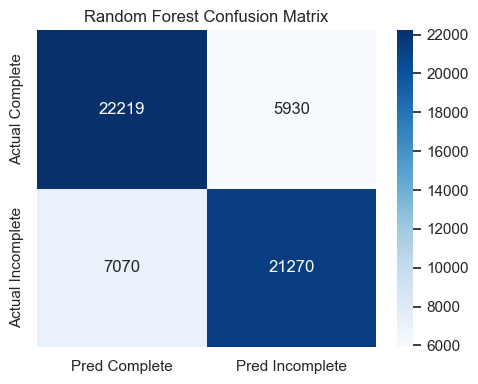

In [6]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_processed)
y_test_pred = best_model.predict(X_test_processed)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Overfitting gap: {train_accuracy - test_accuracy:.4f}")


print("Classification report:\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
cm_df = pd.DataFrame(cm, index=["Actual Complete", "Actual Incomplete"], columns=["Pred Complete", "Pred Incomplete"])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()
